# Define the problem

**Process Management Problem**

In the process management problem, we are given a set of tasks represented by processes $p$. Each process $p_i$ has an associated value $v_i$​ (indicating its importance) and a duration $d_i$​ (representing the time required to execute the task). Additionally, there exists a maximum allowed duration $d_{max}$​ within which we must execute these tasks.


Our objective is to select a subset $S$ of processes from $p$ such that their total duration does not exceed $d_{max}$​, while maximizing the overall value of the executed processes. In other words, we aim to find the set S that maximizes the expression:

$$\sum_{i\in S} v_i$$

subject to the constraint:

$$\sum_{i\in S} d_i \leq d_{max}$$

## Define problem instance

In [1]:
import random 


random.seed(13)

# Define the number of items
n_items = 6

# Define ranges
duration_range = [1, 7]
values_range = [5, 15]
max_duration_percentage = 0.7

# Fill the weights and values 
duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(n_items)]
values  = [random.randint(values_range[0], values_range[1]) for _ in range(n_items)]

# Compute the maximum allowed weight
max_duration = int(max_duration_percentage * sum(duration))


# Print the instance
print("-" * 20)
print("Instance Details:")
print("-" * 20)
print(f"Duration                 : {duration}")
print(f"Values                   : {values}")
print(f"Total duration           : {sum(duration)}")
print(f"Maximum allowed duration : {max_duration}")

--------------------
Instance Details:
--------------------
Duration                 : [3, 3, 6, 6, 7, 7]
Values                   : [7, 15, 8, 15, 7, 8]
Total duration           : 32
Maximum allowed duration : 22


Reference Solution (Selected Processes are **Bolded**):

Duration: [3, **3**, **6**, **6**, 7, **7**]

Values: [7, **15**, **8**, **15**, 7, **8**]

Total selected Duration: 22

Total selected values: 46

# Hackathon Tasks 


## Problem 1

### Build the cost hamiltonians for the Process Management problem:

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

**Our first idea is to use slack variables.**

$y_i$ are slack variables representing the total duration for the selected solution.

$x_i$ encodes the solution as a bit string.

$d_i$ are the durations, $v_i$ are the values, $D$ is the maximum duration.

The cost function is thus

$$
C = A \Big( 1 - \sum_{i=1}^D y_i \Big)^2 + A \Big( \sum_{i=1}^D i y_i - \sum_{i=1}^n x_i d_i \Big)^2 - B \sum_{i=1}^n x_i v_i
$$

We use the $O = \frac{I - Z}{2}$ operator to obtain the Hamiltonian $H$:

$$
H = A \Big( 1 - \sum_{i=1}^D \frac{1 - Z(y_i)}{2} \Big)^2 + A \Big( \sum_{i=1}^D i \frac{1 - Z(y_i)}{2} - \sum_{i=1}^n \frac{1 - Z(x_i)}{2} d_i \Big)^2 - B \sum_{i=1}^n \frac{1 - Z(x_i)}{2} v_i
$$

We set $B = 1$ and $A = \max_i(v_i)$ (to make sure that an extra item for a solution already at the limit is going to be punished).

In [2]:
from qibo.symbols import Z, X
from qibo.hamiltonians import SymbolicHamiltonian

def build_cost_hamiltonian_too_many_qubits(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    """This function should be filled to build the problem cost hamiltonian.

    Args:
        values (list[int]): the list of values.
        duration (list[int]): the list of durations. 
        max_duration (int): the maximum value of the allowed duration. 
    """

    # By convention:
    #   - the qubits 0, ..., D - 1 are the slack variables (y_i).
    #   - the qubits D, ..., D + n - 1 are the solution variables (x_i).
    slack_to_qubit = {
        i: i - 1
        for i in range(1, max_duration + 1)
    }
    solution_to_qubit = {
        i: max_duration + i - 1
        for i in range(1, len(values) + 1)
    }
    B = 1
    A = max(values)

    term_1 = 1 - sum(
        (1 - Z(slack_to_qubit[i]) / 2)
        for i in range(1, max_duration + 1)
    )
    term_2 = sum(
        i * (1 - Z(slack_to_qubit[i]) / 2)
        for i in range(1, max_duration + 1)
    ) - sum(
        duration[i - 1] * (1 - Z(solution_to_qubit[i]) / 2)
        for i in range(1, len(values) + 1)
    )
    term_3 = sum(
        values[i - 1] * (1 - Z(solution_to_qubit[i])) / 2
        for i in range(1, len(values) + 1)
    )
    cost_hamiltonian = A * term_1 ** 2 + A * term_2 ** 2 - B * term_3
    

    return SymbolicHamiltonian(cost_hamiltonian)

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

**But this requires a lot of qubits (28), which is untractable.**

Instead, we use the “log trick”, to encode the “total duration” with binary encoding, instead of the previous “one-shot” encoding. We define $M = \lfloor \ln(D) \rfloor + 1$.

$$
C = A \Big( \sum_{i=0}^{M-1} 2^i y_{i+1} + (D + 1 - 2^M) y_{M} - \sum_{i=1}^n x_i d_i \Big)^2 - B \sum_{i=1}^n x_i v_i
$$

$$
H = A \Big( \sum_{i = 0}^{M - 1} 2^i \frac{1 - Z(y_{i+1})}{2} + (D + 1 - 2^M) \frac{1 - Z(y_M)}{2} - \sum_{i=1}^n \frac{1 - Z(x_i)}{2} d_i \Big)^2 - B \sum_{i=1}^n \frac{1 - Z(x_i)}{2} v_i
$$

In [3]:
def build_cost_hamiltonian(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    # By convention:
    #   - the qubits 0, ..., M are the slack variables (y_i).
    #   - the qubits M + 1, ..., M + D are the solution variables (x_i).
    M = math.floor(math.log(max_duration))

    B = 1
    A = max(values)

    cost_hamiltonian = A * (
        sum(
            2**j * (1 - Z(j)) / 2
            for j in range(0, M)  # 0, ..., M - 1
        ) +
        (max_duration + 1 - 2**M) * (1 - Z(M)) / 2 -
        sum(
            duration[i] * (1 - Z(M + i + 1)) / 2
            for i in range(0, len(values))
        )
    )**2 - B * (
        sum(
            values[i] * (1 - Z(M + i + 1)) / 2
            for i in range(0, len(values))
        )
    )
    

    return SymbolicHamiltonian(cost_hamiltonian)

### Compute the number fo qubits required to execute the cost hamiltonian

In [4]:
# define the number of qubits:
import math

M = math.floor(math.log(max_duration))
nqubits= len(values) + M + 1

### Diagonalize the cost hamiltonian and examen its eigenvalues and eigenvectors. 
- Show that the ground state eigenvector does actually correspond to the ground state energy of the problem. (Note: the ground state could be degenerate)

In [5]:
import numpy as np
from qibo import set_backend

# set the backend used for the calculation 
set_backend("numpy", platform=None)


# create the cost Hamiltonian for the given graph
cost_hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)

ham_matrix = cost_hamiltonian.matrix

eig_val, eig_vec = np.linalg.eig(ham_matrix)
eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]

vec = zip(eig_val, eig_vec)
diagonalized_solution = sorted(vec, key=lambda x: x[0])

print()
print(diagonalized_solution)

[Qibo 0.2.7|INFO|2024-05-05 09:25:26]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 09:25:26]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.



[((-46+0j), '1111011101'), ((-45+0j), '0011110101'), ((-45+0j), '1101111100'), ((-45+0j), '1111011110'), ((-44+0j), '0011110110'), ((-38+0j), '0001011100'), ((-38+0j), '0011111001'), ((-38+0j), '1001010101'), ((-38+0j), '1111101101'), ((-37+0j), '0011111010'), ((-37+0j), '1001010110'), ((-37+0j), '1011110011'), ((-37+0j), '1111101110'), ((-31+0j), '0011001101'), ((-31+0j), '0111011101'), ((-31+0j), '1001011001'), ((-30+0j), '0001101100'), ((-30+0j), '0011001110'), ((-30+0j), '0011111100'), ((-30+0j), '0101010011'), ((-30+0j), '0101111100'), ((-30+0j), '0111011110'), ((-30+0j), '1001011010'), ((-30+0j), '1001100101'), ((-30+0j), '1011000111'), ((-30+0j), '1011110101'), ((-30+0j), '1101110101'), ((-30+0j), '1111010111'), ((-29+0j), '1001100110'), ((-29+0j), '1011110110'), ((-29+0j), '1101110110'), ((-23+0j), '0001010101'), ((-23+0j), '0101010101'), ((-23+0j), '0111101101'), ((-23+0j), '1001011100'), ((-23+0j), '1001101001'), ((-23+0j), '1011001011'), ((-23+0j), '1011111001'), ((-23+0j),

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

We find the right solution: `(-46+0j), '1111011101'`, which resolves to `'011101'` without the slack qubits.

## Problem 2

### Given that we only have **6 qubits** to solve this problem. Reduce the hamiltonian to use **only 6 qubits**.

In [6]:
nqubits = 6

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

To reduce the number of qubits, we decide to get rid of the slack variables (thanks Amir), and define a penalty only with the $x_i$ variables.
To do so, we decompose the cost function $C$ in:

- $C_v$, the cost related to the value of the selected items.
- $C_p$, an extra penalty for the states which are not valid (i.e. which have a total duration > $D$).

$$C = C_v + C_p$$

$$
C_v = -\sum_{i=1}^n x_i v_i
$$

**Proposal 1 for $C_p$**

Since we are restricted to linear and quadratic functions, we suggest the following for $C_p$:

$$
C_p = \alpha \times d \times (d - D)
$$

where $\alpha$ is a parameter that should be tuned, and $d$ is the duration for a state $x$:

$$
d = \sum_{i=1}^n x_i d_i
$$

This first proposal comes from the fact that the roots of $C_p$ are $0$ and $D$, **which seems intuitive**: **the values between $0$ and $D$ get a little “boost”, the values after $D$ are penalized.**

Note that there are two variables associated with $C_p$:

- The maximum cost reduction $\epsilon$ given to the “valid” states, lower is better. $\epsilon = \frac{D^2 \alpha}{4}$
- The minimum penalty given to the “invalid” states, that is when $d \geq D + 1$ (since everything is in the integer realm), bigger is better. $\Delta P = \alpha (D + 1)$.

As we can see, $\epsilon$ and $\Delta P$ evolve in the same direction depending on $\alpha$, so there is a tradeoff to make. With the previous formulation, one can set $\epsilon$ to a value $\epsilon_0$, and then derive derive $\alpha = \frac{4 \epsilon_0}{D^2}$. Then, $\Delta P = 4 \epsilon_0 \frac{D + 1}{D^2}$.

We suggest to take $\epsilon_0 = \max_i v_i$, so the maximal cost reduction is equivalent to having a “free” item on your bag.

**Proposal 2 for $C_p$**

We follow [Unbalanced penalization: A new approach to encode inequality constraints of combinatorial problems for quantum optimization algorithm](https://arxiv.org/pdf/2211.13914) and slightly change $C_p$:

$$
C_p = \alpha (d - D) + \beta (d - D)^2
$$

This paper optimized the parameters $\alpha$ and $\beta$ against a large number of random knapsack problem instances.

We inject the parameters found in the paper: $\alpha = 0.9603$, $\beta = 0.0371$.

To get an intuition of what's behind these functions, we plot them in `[0, D + 20]`.

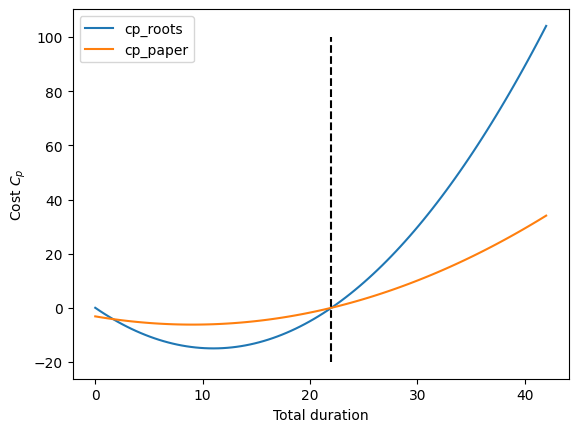

In [7]:
import matplotlib.pyplot as plt


def cp_roots(d, values: list[int], max_duration: int):
    alpha = 4 * max(values) / (max_duration**2)
    return alpha * d * (d - max_duration)


def cp_paper(d, values: list[int], max_duration: int):
    return 0.9603 * (d - max_duration) + 0.0371 * (d - max_duration)**2


ds = np.linspace(0, max_duration + 20, 100)
plt.plot(ds, cp_roots(ds, values, max_duration), label='cp_roots')
plt.plot(ds, cp_paper(ds, values, max_duration), label='cp_paper')
plt.vlines([22], -20, 100, linestyle='dashed', color='black')
plt.xlabel('Total duration')
plt.ylabel('Cost $C_p$')
plt.legend()

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

As expected, `cp_roots` is symmetrical around `max(duration) / 2` = 11, and its minimum value (so the biggest possible “boost” offered to the valid states) is 15, which is `max(values)`.

`cp_paper` has a less agressive penalty for the invalid states, but the “boost” for the valid states are much more uniform.

We are now comparing the Hamiltonians obtained with these functions.

In [8]:
def build_cv_hamiltonian(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    h = -sum(
        values[i] * (1 - Z(i)) / 2
        for i in range(0, len(values))
    )
    return SymbolicHamiltonian(h)


def build_cp_hamiltonian(cp, values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    d = sum(
        duration[i] * (1 - Z(i)) / 2
        for i in range(0, len(duration))
    )
    h = cp(d, values, max_duration)
    return SymbolicHamiltonian(h)


def get_hamiltonian_eig(h: SymbolicHamiltonian):
    """Return a list of (eigenstate, eigenvalue)"""
    set_backend("numpy", platform=None)
    ham_matrix = h.matrix

    eig_val, eig_vec = np.linalg.eig(ham_matrix)
    eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]
    return dict(zip(eig_vec, eig_val))


def get_hamiltonian_eigs(cp, values: list[int], duration: list[int], max_duration: int):
    cv_hamiltonian = build_cv_hamiltonian(values, duration, max_duration)
    cv_eigs = get_hamiltonian_eig(cv_hamiltonian)
    
    cp_hamiltonian = build_cp_hamiltonian(cp, values, duration, max_duration)
    cp_eigs = get_hamiltonian_eig(cp_hamiltonian)
    
    return {
        eigenstate: {
            'cv': cv_eigs[eigenstate],
            'cp': cp_eigs[eigenstate],
            'c': cv_eigs[eigenstate] + cp_eigs[eigenstate],
        }
        for eigenstate in cv_eigs
    }


cp_roots_eigs = get_hamiltonian_eigs(cp_roots, values, duration, max_duration)
cp_paper_eigs = get_hamiltonian_eigs(cp_paper, values, duration, max_duration)

[Qibo 0.2.7|INFO|2024-05-05 09:25:29]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 09:25:29]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|INFO|2024-05-05 09:25:29]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 09:25:29]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|INFO|2024-05-05 09:25:29]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 09:25:29]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|INFO|2024-05-05 09:25:29]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 09:25:30]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [9]:
import matplotlib.pyplot as plt


def plot_eigs(eigs):
    best = '011101'
    state_is_valid = {
        eigenstate: sum(
            int(x) * duration
            for x, duration in zip(eigenstate, duration)
        ) < max_duration
        for eigenstate in eigs
    }

    fig, ax = plt.subplots(
        figsize=(15, 10),
        ncols=3,
    )

    for eigenstate, eigenvals in eigs.items():
        color = "blue" if eigenstate == best else "green" if state_is_valid[eigenstate] else "red"
        ax[0].barh(eigenstate, eigenvals['c'], color=color)
        ax[1].barh(eigenstate, eigenvals['cv'], color=color)
        ax[2].barh(eigenstate, eigenvals['cp'], color=color)

    ax[0].set_title('Total cost')
    ax[1].set_title('Value cost')
    ax[2].set_title('Penalty cost')

plt.show()

In [10]:
def get_duration(state):
    return sum(int(x) * d for x, d in zip(state, duration))


def get_values(state):
    return sum(int(x) * d for x, d in zip(state, values))


def print_summary(state):
    print(f'Solution: {state}')
    print(f'Duration: {get_duration(state)} {"(INVALID)" if get_duration(state) > max_duration else ""}')
    print(f'Value: {get_values(state)}')


def print_summary_eigs(eigs):
    best = min(eigs.items(), key=lambda items: items[1]['c'])[0]
    print_summary(best)

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

**In the following plots, invalid states are in red, valid states are in green, the optimal state is in blue.**

### With `cp_roots`

/home/piwakk/micromamba/envs/eth-hack/lib/python3.11/site-packages/matplotlib/transforms.py:766: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


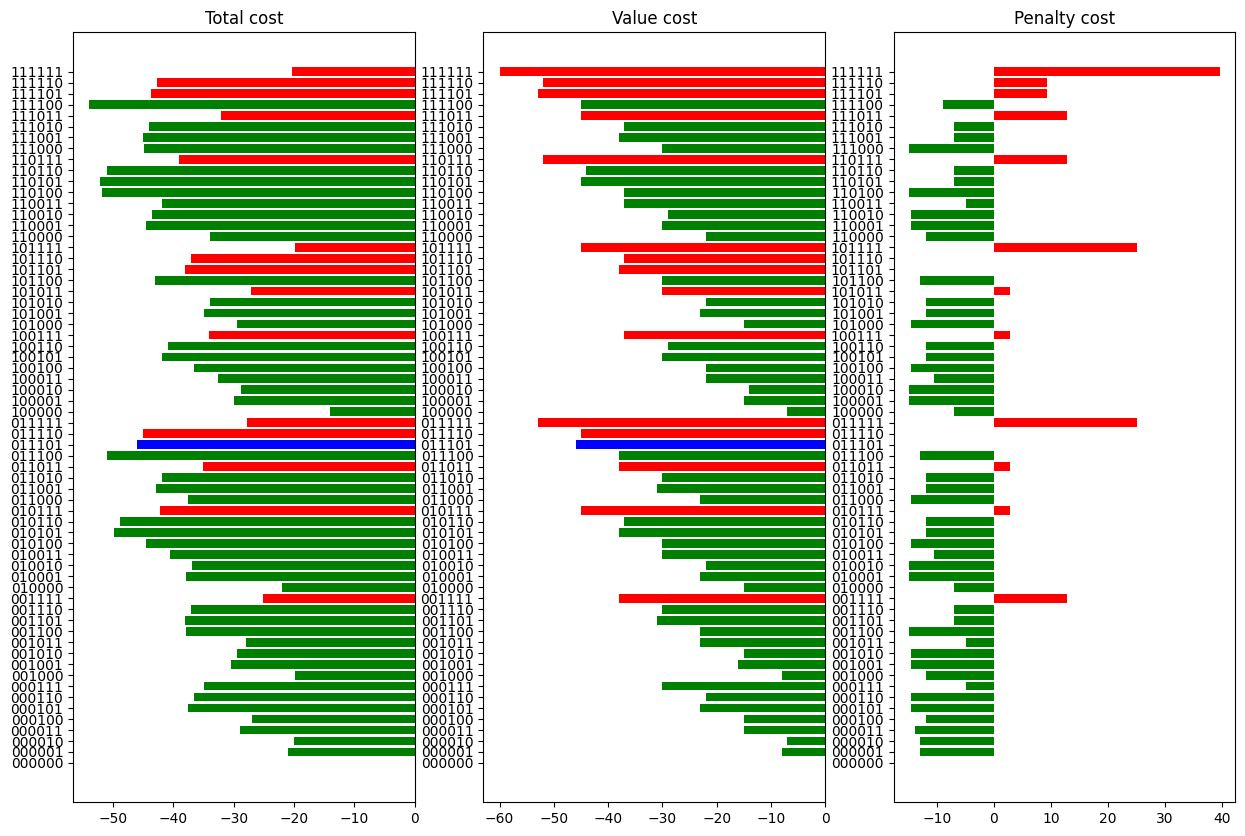

In [11]:
plot_eigs(cp_roots_eigs)

In [12]:
print_summary_eigs(cp_roots_eigs)

Solution: 111100
Duration: 18 
Value: 45


```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

**This Hamiltonian does not have the optimal solution as a ground state, but `45` is quite close to `46`**

### With `cp_paper`

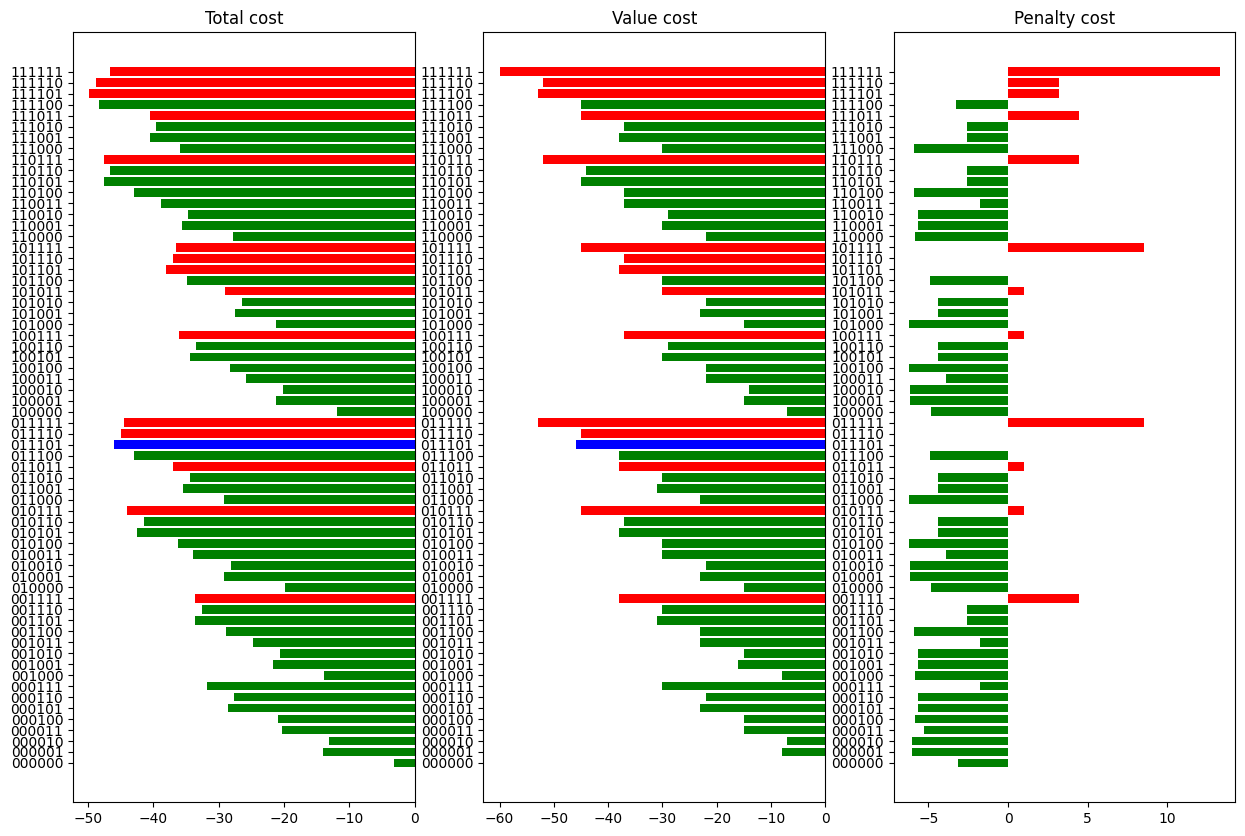

In [13]:
plot_eigs(cp_paper_eigs)

In [14]:
print_summary_eigs(cp_paper_eigs)

Solution: 111101
Duration: 25 (INVALID)
Value: 53


```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

**This Hamiltonian does not yield a valid solution, because it does not penalize the invalid states enough.**

### Solve this hamiltonian using the QAOA algorithm. 

        step 1. Define the Mixing hamiltonian.

In [15]:
def build_mixer_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    mixing_hamiltonian = sum((X(i)) for i in range(6))
    return SymbolicHamiltonian(mixing_hamiltonian)

        Step 2. Run the QAOA algorithm.

#### With `cp_roots`

In [16]:
from qibo import models

# We plug in our hamiltonian.
cv_hamiltonian = build_cv_hamiltonian(values, duration, max_duration)
cp_hamiltonian = build_cp_hamiltonian(cp_roots, values, duration, max_duration)
hamiltonian = cv_hamiltonian + cp_hamiltonian

mixer_hamiltonian = build_mixer_hamiltonian(nqubits)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with four layers 
n_layers = 5
# initial_parameters = 0.01 * np.random.random(n_layers * 2)
initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi
print(initial_parameters)

# run the QAOA optimization with the initial parameters and the hamiltonians defined 

# Define random initial variational parameters with four layers 
n_layers = 4
initial_parameters = 0.01 * np.random.random(n_layers * 2)


"""
supported optimization Method: 
- Nelder-Mead 
- parallel_L-BFGS-B
- Powell
- CG
- cma
- sgd
- L-BFGS-B
- Newton-CG
- COBYLA
- BFGS
- trust-constr
"""
method = "Powell"


best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)

print("best energy: ", best_energy)

[-0.01587549 -0.00222994 -0.01634896  0.02875241 -0.01799323  0.0124168
 -0.01758387 -0.01301767  0.02851888 -0.02910377]
best energy:  -44.78550735121512


    Step 3. Display solution and compare it to the ground state you obtained in problem 1

In [17]:
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(None)

probabilities = (np.abs(quantum_state) ** 2)
probabilities = zip(probabilities, [i for i in range(len(probabilities))])
probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
print(probabilities)
qaoa_roots_solution = probabilities[0][1]

[('13.52 %', '110101'), ('11.70 %', '110110'), ('6.33 %', '010110'), ('5.66 %', '111001'), ('5.35 %', '111010'), ('4.02 %', '011110'), ('3.82 %', '010101'), ('3.40 %', '100110'), ('3.02 %', '111100'), ('2.70 %', '011010'), ('2.59 %', '011101'), ('2.54 %', '101110'), ('2.34 %', '110100'), ('2.28 %', '001101'), ('2.20 %', '000101'), ('2.10 %', '011001'), ('2.00 %', '111101'), ('1.52 %', '100101'), ('1.38 %', '101010'), ('1.33 %', '110001'), ('1.28 %', '101101'), ('1.28 %', '110011'), ('1.18 %', '011100'), ('1.15 %', '001110'), ('1.13 %', '101001'), ('1.07 %', '110010'), ('1.05 %', '101100'), ('0.97 %', '111110'), ('0.87 %', '100010'), ('0.84 %', '110000'), ('0.71 %', '000111'), ('0.70 %', '111000'), ('0.56 %', '000010'), ('0.55 %', '010100'), ('0.51 %', '000001'), ('0.50 %', '010011'), ('0.49 %', '001011'), ('0.48 %', '001001'), ('0.47 %', '010010'), ('0.47 %', '100011'), ('0.39 %', '100111'), ('0.37 %', '001100'), ('0.36 %', '010111'), ('0.28 %', '000100'), ('0.24 %', '011111'), ('0.21 

#### With `cp_paper`

In [18]:
from qibo import models

# We plug in our hamiltonian.
cv_hamiltonian = build_cv_hamiltonian(values, duration, max_duration)
cp_hamiltonian = build_cp_hamiltonian(cp_paper, values, duration, max_duration)
hamiltonian = cv_hamiltonian + cp_hamiltonian

mixer_hamiltonian = build_mixer_hamiltonian(nqubits)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with four layers 
n_layers = 5
# initial_parameters = 0.01 * np.random.random(n_layers * 2)
initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi
print(initial_parameters)

# run the QAOA optimization with the initial parameters and the hamiltonians defined 

# Define random initial variational parameters with four layers 
n_layers = 4
initial_parameters = 0.01 * np.random.random(n_layers * 2)


"""
supported optimization Method: 
- Nelder-Mead 
- parallel_L-BFGS-B
- Powell
- CG
- cma
- sgd
- L-BFGS-B
- Newton-CG
- COBYLA
- BFGS
- trust-constr
"""
method = "Powell"


best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)

print("best energy: ", best_energy)

[ 0.01842394 -0.01493489  0.01640945 -0.01348082 -0.01362665  0.01831196
  0.02952363  0.00038043 -0.02681923  0.00248686]
best energy:  -38.3460888375071


In [19]:
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(None)

probabilities = (np.abs(quantum_state) ** 2)
probabilities = zip(probabilities, [i for i in range(len(probabilities))])
probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
print(probabilities)
qaoa_paper_solution = probabilities[0][1]

[('10.93 %', '111110'), ('8.35 %', '111100'), ('8.18 %', '111101'), ('6.25 %', '001101'), ('4.46 %', '110001'), ('4.12 %', '101101'), ('4.08 %', '110101'), ('2.89 %', '001011'), ('2.69 %', '101100'), ('2.54 %', '101110'), ('2.42 %', '111000'), ('2.30 %', '001000'), ('2.12 %', '111111'), ('2.09 %', '000101'), ('2.05 %', '110000'), ('1.95 %', '110110'), ('1.83 %', '011011'), ('1.76 %', '110100'), ('1.63 %', '000111'), ('1.63 %', '011001'), ('1.60 %', '001111'), ('1.39 %', '001010'), ('1.38 %', '011110'), ('1.14 %', '011111'), ('1.11 %', '010001'), ('1.05 %', '001100'), ('1.03 %', '110111'), ('1.02 %', '100111'), ('0.95 %', '111011'), ('0.93 %', '101001'), ('0.91 %', '010101'), ('0.87 %', '010011'), ('0.80 %', '101010'), ('0.79 %', '011010'), ('0.78 %', '010111'), ('0.77 %', '000001'), ('0.72 %', '010110'), ('0.72 %', '100101'), ('0.71 %', '111001'), ('0.62 %', '001001'), ('0.60 %', '010010'), ('0.55 %', '100011'), ('0.47 %', '000010'), ('0.43 %', '100010'), ('0.42 %', '010000'), ('0.37 %

In [20]:
print('With cp_roots')
print_summary(qaoa_roots_solution)

print()
print('With cp_paper')
print_summary(qaoa_paper_solution)

With cp_roots
Solution: 110101
Duration: 19 
Value: 45

With cp_paper
Solution: 111110
Duration: 25 (INVALID)
Value: 52


```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

**For `cp_roots`, QAOA yields `010110`, which is far from the optimum (37 vs 45 for the ground state of the Hamiltonian).**

**QAOA does find the ground state of `cp_paper` (but this is not a valid state, as we know).**

### Solve this hamiltonian using Quantum Adiabatic Evolution

        Setp 1. Define initial hamiltonian

In [21]:
def build_initial_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    mixing_hamiltonian = sum((X(i)) for i in range(6))
    return SymbolicHamiltonian(mixing_hamiltonian)

    Step 2. Run the Adiabatic Evolution

#### With `cp_roots`

In [22]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian


# build initial (H0) and target (H1) hamiltonians
H0 = build_initial_hamiltonian(nqubits=nqubits)

# We plug in our hamiltonian.
cv_hamiltonian = build_cv_hamiltonian(values, duration, max_duration)
cp_hamiltonian = build_cp_hamiltonian(cp_roots, values, duration, max_duration)
H1 = cv_hamiltonian + cp_hamiltonian

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.calculate_dense().matrix)
H0_dense = Hamiltonian(nqubits, H0.calculate_dense().matrix)

# Define the time steps
dt = 0.1

# Define the final evolution time
T = 20

# define the schedule. This is a function of time that defines the scheduling of the adiabatic evolution. 
# Can be either a function of time s(t) or a function with two arguments s(t, p) 
# where p corresponds to a vector of parameters to be optimized.
def s(t): return t

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T)

    Step 3. Display solution and compare it to the ground state you obtained in problem 1 and using QAOA

In [23]:
# obtain the state with the highest probability
solution_dec  = (np.abs(adiabatic_quantum_state) ** 2).argmax()
adiabatic_roots_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

#### With `cp_paper`

In [24]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian


# build initial (H0) and target (H1) hamiltonians
H0 = build_initial_hamiltonian(nqubits=nqubits)

# We plug in our hamiltonian.
cv_hamiltonian = build_cv_hamiltonian(values, duration, max_duration)
cp_hamiltonian = build_cp_hamiltonian(cp_paper, values, duration, max_duration)
H1 = cv_hamiltonian + cp_hamiltonian

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.calculate_dense().matrix)
H0_dense = Hamiltonian(nqubits, H0.calculate_dense().matrix)

# Define the time steps
dt = 0.1

# Define the final evolution time
T = 20

# define the schedule. This is a function of time that defines the scheduling of the adiabatic evolution. 
# Can be either a function of time s(t) or a function with two arguments s(t, p) 
# where p corresponds to a vector of parameters to be optimized.
def s(t): return t

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T)

In [25]:
# obtain the state with the highest probability
solution_dec  = (np.abs(adiabatic_quantum_state) ** 2).argmax()
adiabatic_paper_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

In [26]:
print('With cp_roots')
print_summary(adiabatic_roots_solution)

print()
print('With cp_paper')
print_summary(adiabatic_paper_solution)

With cp_roots
Solution: 111100
Duration: 18 
Value: 45

With cp_paper
Solution: 111101
Duration: 25 (INVALID)
Value: 53


```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

Adiabatic evolution finds **both** ground states, it is thus superior to QAOA on that example.

### What are the downsides to the method you used to reduce the number of qubits? 

```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

Our approach to reducing the number of qubits:

- Penalizes the invalid states, which is good.
- But **might modify** the ground state of the Hamiltonian because it gives a “bonus” to some valid states which are not the ground state.

This is problematic if the ground state ends up being far from the actual optimal solution.

As of today, qubits are rare and precious, so this seems like **an acceptable tradeoff** (especially if we don't have enough qubits to solve the full problem…) Furthermore, as the size of the problem increases (i.e. more items), we expect the energy levels to be more evenly distributed, and thus the valid states “bonus” to have **less influence** on the results of the optimization.

## Problem 3

### Given this new dataset generate a hamiltonian that only uses 3 qubits 

In [27]:
import random 


random.seed(13)

# Define the number of items
n_items = 3

# Define ranges
max_duration_percentage = 0.7

# Fill the weights and values 
values   = [6, 2, 6]
duration = [3, 3, 6]

# Compute the maximum allowed weight
max_duration = int(max_duration_percentage * sum(duration))



# Print the instance
print("-" * 20)
print("Instance Details:")
print("-" * 20)
print(f"Duration                 : {duration}")
print(f"Values                   : {values}")
print(f"Total duration           : {sum(duration)}")
print(f"Maximum allowed duration : {max_duration}")

--------------------
Instance Details:
--------------------
Duration                 : [3, 3, 6]
Values                   : [6, 2, 6]
Total duration           : 12
Maximum allowed duration : 8


```
⚠️⚠️⚠️⚠️⚠️ COMMENT ⚠️⚠️⚠️⚠️⚠️
```

The optimal solution is `110`, with a total duration of 6 and a value of 8.

### Design a circuit layout that is suitable for this Hamiltonian

    Step 1. Create each element of the circuit

Your qubits will have a critical current of 230nA, shunting capacitance of 50fF, Z loop capacitance of 4.4fF, inductance of 480pH, x to z loop current ration of 0.4 and junction assymetry of 0.

The coupler's parameters are given

In [28]:
import cas as cas

# coupler parameters
i_sigma = 565
c_sigma = 11
lc = 580
d = 0.0
coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler02 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)

# qubits parameters
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

circuit_elements = [qubit0, coupler01, qubit1, coupler12, qubit2, coupler02]

/home/piwakk/micromamba/envs/eth-hack/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


    Step 2. Define the qubit-coupler interaction and create the circuit object

A good approximation is to consider only the first 5 energy levels of the qubit and the first 2 energy levels of the coupler

In [29]:
m = 65; m_mat = np.zeros((6, 6)) # mutual inductance matrix (given)

m_mat[0, 1] = -m; m_mat[1, 2] = m
m_mat[2, 3] = -m; m_mat[3, 4] = m
m_mat[4, 5] = -m; m_mat[5, 0] = m

m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([5, 2, 5, 2, 5, 2]) # truncation vector for the energies of each element
circuit = cas.AnnealingCircuit(circuit_elements, m_mat, trunc_vec)

### Design an annealing Ising schedule 

    Step 1. Define the starting (initial) and objective hamiltonian coefficients

In [32]:
def z_i(i):
    alpha = 4 * max(values) / (max_duration**2)
    return sum(
        0.5 * (3 * alpha * max_duration * duration[i] + values[i]) - alpha * duration[i] / 2 - duration[i] * duration[j]
        for j in range(0, len(duration))
    )


def z_ij(i, j):
    return duration[i] * duration[j]


# initialization hamiltonian
h0 = {
    'x_0': 1.0,
    'x_1': 1.0,
    'x_2': 1.0,
    'z_0': 0.0,
    'z_1': 0.0,
    'z_2': 0.0,
    'zz_0,1': 0.0,
    'zz_1,2': 0.0,
    'zz_0,2': 0.0,
}

# objective hamiltonian
hf = {
    'x_0': 0.0,
    'x_1': 0.0,
    'x_2': 0.0,
    'z_0': z_i(0),
    'z_1': z_i(1),
    'z_2': z_i(2),
    'zz_0,1': z_ij(0, 1),
    'zz_1,2': z_ij(1, 2),
    'zz_0,2': z_ij(0, 2),
}

# For proposal 1
hf = {
    'x_0': 0.0,
    'x_1': 0.0,
    'x_2': 0.0,
    'z_0': 2.2561983471074380,
    'z_1': 0.2561983471074380,
    'z_2': 1.5123966942148760,
    'zz_0,1': 0.55785123966942149,
    'zz_1,2': 1.1157024793388430,
    'zz_0,2': 1.1157024793388430,
}

    Step 2. Create a method to get a an arbitrary schedule for the circuit designed above

    Step 2. Get the ising coefficients for a linear and an exponential schedule for a resolution of 1ns

In [33]:
def get_schedule(h0: dict[str, np.ndarray], hf: dict[str, np.ndarray], points: int, schedule: callable) -> dict[str, int | np.ndarray]:
    """Given the ising coefficients for the initial and final hamiltonian of the annealing scheduel,
    and given some time dependance of the schedule (eg. linear, exponential, etc), returns the ising
    coefficients for x and z at each time step.

    args:
        h0 (dict[str, np.ndarray]): ising coefficients of the starting hamiltonian h0
        hf (dict[str, np.ndarray]): ising coefficients of the target (final) hamiltonian hf
        points (int): number of points in the annealing schedule
        schedule (callable): time dependance of the schedule
    
    returns:
        dict[str, np.ndarray]: Dictionary of ising coefficients at each step of the schedule
    """

    ising_dict = {'points': points}

    for key in h0:
        h0_c, hf_c = h0[key], hf[key]
        ising_dict[key] = schedule(h0_c, hf_c, points) * 2 * np.pi

    return ising_dict


def linear_schedule():
    def _schedule(h0_c, hf_c, points):
        return np.linspace(h0_c, hf_c, points)
    return _schedule


def exponential_schedule(lam):
    def _schedule(h0_c, hf_c, points):
        x = np.exp(-lam * np.linspace(0, 1, points))
        return h0_c * x + hf_c * (1 - x)
    return _schedule


ising_linear = get_schedule(h0, hf, points=10, schedule=linear_schedule())
ising_exponential = get_schedule(h0, hf, points=10, schedule=exponential_schedule(lam=5))

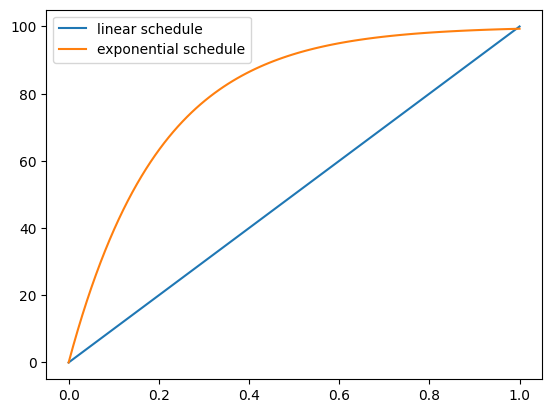

In [48]:
plt.plot(np.linspace(0, 1, 100), linear_schedule()(0, 100, 100), label="linear schedule")
plt.plot(np.linspace(0, 1, 100), exponential_schedule(lam=5)(0, 100, 100), label="exponential schedule")
plt.legend()

    Step 3. Calculate the flux schedule for the exponential schedule

In [52]:
def get_fluxes(ising_schedule: dict[str, int | np.ndarray], optimizer: str) ->  dict[str, int | np.ndarray]:
    """Get the flux schedule from a given ising schedule.

    Args:
        ising_schedule (dict[str, int  |  np.ndarray]): dictionary with the number of points in the schedule
            and the ising coefficients for each control of the circuit at each point of the schedule
        optimizer (str): name of the lmfit minimizer to use

    Returns:
        dict[str, int | np.ndarray]: dictionary containing the number of points in the schedule and the fluxes
            to be applied at each control of the circuit at each point of the schedule.
    """
    flux_dict = circuit.get_custom_fluxes_pwsw(ising_schedule, verbose=True, optimizer_method=optimizer)
    return flux_dict


def get_schedule_spectrum(flux_dict: dict[str, int | np.ndarray], levels: int) -> np.ndarray:
    """Calculate the energy spectrum through the schedule. The more levels we try to calculate,
    the more computationally expensive this will be.

    Args:
        flux_dict (dict[str, int  |  np.ndarray]): dictionary containing the number of points in the schedule and the fluxes
            to be applied at each control of the circuit at each point of the schedule.
        levels (int): energy levels to compute

    Returns:
        np.ndarray: of size (schedule points, levels) with the energy gaps for each level (En - E0),
            where E0 is the ground state energy and En is the energy of level n.
    """
    return circuit.calculate_spectrum(flux_dict, levels=levels)

### Linear schedule

In [54]:
linear_fluxes = get_fluxes(ising_linear, "leastsq")
print(linear_fluxes)

linear_spectrum = get_schedule_spectrum(linear_fluxes, levels=5)
print(linear_spectrum)

calculating qubit biases for qubit 1 of 3
point #8 single qubit residuals: 
 [0.0454779  0.45398585] 

calculating qubit biases for qubit 2 of 3
point #9 single qubit residuals: 
 [-9.18967186e-02  1.63921518e-05] 

calculating qubit biases for qubit 3 of 3
point #9 single qubit residuals: 
 [-0.09698965  0.00011323] 


 calculating coupler bias for coupler 1 of 3
schedule point 10 / 10
 calculating coupler bias for coupler 2 of 3
schedule point 10 / 10
 calculating coupler bias for coupler 3 of 3
{'points': 10, 'phix_0': array([4.58150436, 4.61120475, 4.6445839 , 4.68157648, 4.7225947 ,
       4.76885401, 4.8232002 , 4.89275995, 5.00011994, 6.28316714]), 'phiz_0': array([0.        , 0.00700784, 0.01292468, 0.01789086, 0.022057  ,
       0.02555933, 0.02849667, 0.03089259, 0.03141593, 0.02963563]), 'phix_1': array([3.14159265, 4.21840028, 4.65204592, 4.91551449, 5.07306075,
       5.18581506, 5.25360033, 5.27815777, 5.25690952, 4.95181564]), 'phiz_1': array([0., 0., 0., 0., 0., 0., 0.,

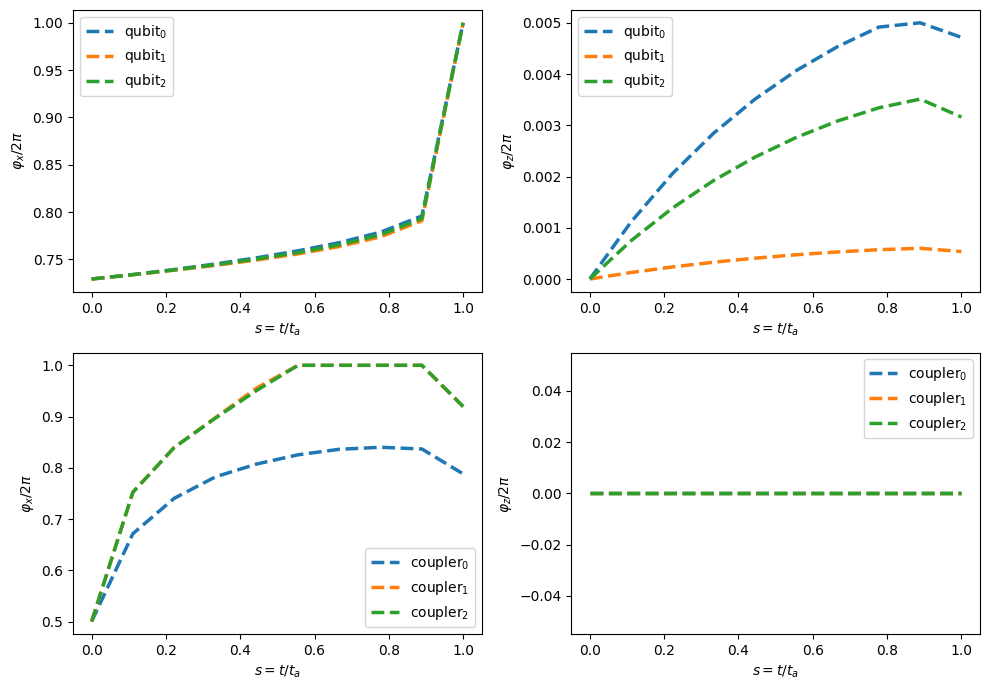

In [55]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

s = linear_schedule()(0, 1, 10)

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    plt.plot(s, linear_fluxes["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    plt.plot(s, linear_fluxes["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)

for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, linear_fluxes["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, linear_fluxes["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
plt.show()

### Exponential schedule

In [57]:
exponential_fluxes = get_fluxes(ising_exponential, "leastsq")
print(exponential_fluxes)

exponential_spectrum = get_schedule_spectrum(exponential_fluxes, levels=5)
print(exponential_spectrum)

calculating qubit biases for qubit 1 of 3
point #4 single qubit residuals: 
 [0.04724304 0.46502283] 



/home/piwakk/code/CAS/cas/elements.py:617: UserWarning: For the point #4, solver found solutions that are not optimal. The relative error is 3.69 % for single qubit residuals
  warnings.warn(


point #5 single qubit residuals: 
 [0.08131863 0.56693443] 



/home/piwakk/code/CAS/cas/elements.py:617: UserWarning: For the point #5, solver found solutions that are not optimal. The relative error is 4.31 % for single qubit residuals
  warnings.warn(


point #6 single qubit residuals: 
 [0.10282744 0.48284383] 



/home/piwakk/code/CAS/cas/elements.py:617: UserWarning: For the point #6, solver found solutions that are not optimal. The relative error is 3.61 % for single qubit residuals
  warnings.warn(


point #7 single qubit residuals: 
 [0.09943939 0.30379904] 



/home/piwakk/code/CAS/cas/elements.py:617: UserWarning: For the point #7, solver found solutions that are not optimal. The relative error is 2.30 % for single qubit residuals
  warnings.warn(


calculating qubit biases for qubit 2 of 3
calculating qubit biases for qubit 3 of 3
schedule point 10 / 10
 calculating coupler bias for coupler 1 of 3
schedule point 10 / 10
 calculating coupler bias for coupler 2 of 3


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 2 can not provide the required coupling strength of 0.75 GHz for point 2 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 2 can not provide the required coupling strength of 0.90 GHz for point 3 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 2 can not provide the required coupling strength of 0.99 GHz for point 4 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 2 can not provide the required coupling strength of 1.05 GHz for point 5 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 2 can not provide the required coupling strength of 1.08 GHz for point 6 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 2 can not provide the required coupling strength of 1.09 GHz for point 7 in schedule. Using maximum available strength instead.
  warnings.warn(


schedule point 10 / 10
 calculating coupler bias for coupler 3 of 3


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 3 can not provide the required coupling strength of 0.75 GHz for point 2 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 3 can not provide the required coupling strength of 0.90 GHz for point 3 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 3 can not provide the required coupling strength of 0.99 GHz for point 4 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 3 can not provide the required coupling strength of 1.05 GHz for point 5 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 3 can not provide the required coupling strength of 1.08 GHz for point 6 in schedule. Using maximum available strength instead.
  warnings.warn(


/home/piwakk/code/CAS/cas/circuit.py:1672: UserWarning: Coupler 3 can not provide the required coupling strength of 1.09 GHz for point 7 in schedule. Using maximum available strength instead.
  warnings.warn(


{'points': 10, 'phix_0': array([4.58150436, 4.71556354, 4.82545082, 4.91898822, 5.00394231,
       5.09005763, 5.18034658, 5.27677738, 5.37622161, 5.47835821]), 'phiz_0': array([0.        , 0.02142341, 0.02859588, 0.03141593, 0.03141593,
       0.03141593, 0.03141593, 0.03141593, 0.03141593, 0.03118201]), 'phix_1': array([3.14159265, 5.05040251, 5.25518818, 5.27757397, 5.25546948,
       5.21634675, 5.17088322, 5.12691083, 5.08750001, 5.05297341]), 'phiz_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'phix_2': array([4.58150436, 4.70169298, 4.79938038, 4.88735636, 4.97190631,
       5.05650786, 5.14348648, 5.23484767, 5.33284069, 5.44062484]), 'phiz_2': array([0.        , 0.00247888, 0.00333212, 0.00366043, 0.00377122,
       0.00378182, 0.00374586, 0.00368985, 0.00362713, 0.0035642 ]), 'phix_3': array([3.14159265, 5.91663066, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.25342119, 6.06991701]), 'phiz_3': array([0., 0., 0., 0., 0., 0., 0., 0., 0

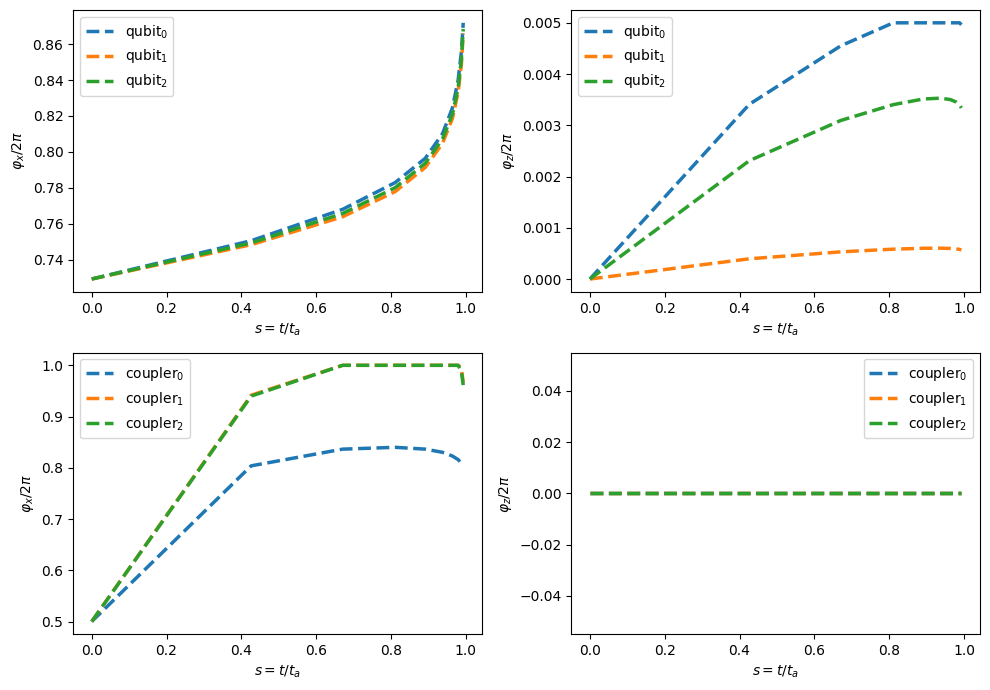

In [59]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

s = exponential_schedule(lam=5)(0, 1, 10)

ax1 = plt.subplot(2, 2, 1)
for i, qubit_index in enumerate(circuit.qubit_indices):
    plt.plot(s, exponential_fluxes["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    plt.plot(s, exponential_fluxes["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)

for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, exponential_fluxes["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, exponential_fluxes["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
    
plt.tight_layout()
plt.show()

### Energy gaps

We compute the energy gap $\Delta_{min}$.

In [51]:
linear_spectrum[:,1] - linear_spectrum[:,0]

array([12.32717144,  9.93872016,  7.90724226,  6.30716531,  5.46999251,
        5.91690803,  7.24440567,  8.7941334 , 10.10394535,  9.44525394])

This is what $T$ _should_ be to respect the adiabatic theorem.

In [56]:
1 / max(spectrum[:,1] - spectrum[:,0])**2

0.006580715685351379

### Research questions

1. For the annealing schedules calculated, do any of the resulting spectral schedules fulfill the adiabatic theorem?
2. By this point you will have obtained two energies, one from the software challenge (QAOA) and one from the annealing schedule above. Argue their relation.
3.  If you have made it here, you have problaly seen the difficulties of solving small instances. Can you propose ways to scale these procedures to more qubits? Some techniques for finding the gap along the annealing process can be found in [1], [2], [3] and [4]. Can you implement a simulation from one of these papers? Research and propose better techniques to find the flux schedule for a given Ising schedule with a greater amount of qubits.  

## Bibliography

[1] Adiabatic Spectroscopy and a Variational Quantum Adiabatic Algorithm: https://arxiv.org/abs/2103.01226

[2] Direct estimation of the energy gap between the ground state and excited state with quantum annealing: https://arxiv.org/abs/2007.10561

[3] Simulating quantum circuits by adiabatic computation: improved spectral gap bounds: https://arxiv.org/abs/1906.05233

[4] Spectroscopy on two coupled flux qubits: https://arxiv.org/abs/cond-mat/0308192

